In [1]:
import numpy as np

In [2]:
for (a,b) in zip(np.array([1,2,3]), np.array([4,5,6])):
    print(a,b)

1 4
2 5
3 6


# Imports

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler

# Create Dataset and Dataloader

In [2]:
# Define data root directory
data_dir = "../data/power_consumption/"
print(os.listdir(data_dir))

['DAYTON_hourly.csv', 'FE_hourly.csv', 'DOM_hourly.csv', 'AEP_hourly.csv', 'NI_hourly.csv', 'DEOK_hourly.csv', 'est_hourly.paruqet', 'COMED_hourly.csv', 'DUQ_hourly.csv', 'PJMW_hourly.csv', 'EKPC_hourly.csv', 'PJM_Load_hourly.csv', 'pjm_hourly_est.csv', 'PJME_hourly.csv']


In [3]:
pd.read_csv(data_dir + 'AEP_hourly.csv').head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [4]:
force_restart = False
batch_size = 1024

try:
    test_x = torch.load("../processed_data/test_x.pt")
    test_y = torch.load("../processed_data/test_y.pt")
    label_scalers = torch.load("../models/label_scalers.sc")
    train_data = torch.load("../processed_data/train_data.pt")
    train_loader = torch.load("../processed_data/train_loader.pt")
except FileNotFoundError:
    force_restart = True

if force_restart:
    label_scalers = {}

    train_x = []
    test_x = {}
    test_y = {}

    for file in tqdm(os.listdir(data_dir)): 
        # Skipping the files we're not using
        if file[-4:] != ".csv" or file == "pjm_hourly_est.csv":
            continue

        df = pd.read_csv(data_dir + file, parse_dates=[0])

        df['hour'] = df.apply(lambda x: x['Datetime'].hour,axis=1)
        df['dayofweek'] = df.apply(lambda x: x['Datetime'].dayofweek,axis=1)
        df['month'] = df.apply(lambda x: x['Datetime'].month,axis=1)
        df['dayofyear'] = df.apply(lambda x: x['Datetime'].dayofyear,axis=1)
        df = df.sort_values("Datetime").drop("Datetime",axis=1)
        

        sc = MinMaxScaler()
        label_sc = MinMaxScaler()
        data = sc.fit_transform(df.values)

        label_sc.fit(df.iloc[:,0].values.reshape(-1,1))
        label_scalers[file] = label_sc
        

        lookback = 90
        inputs = np.zeros((len(data)-lookback,lookback,df.shape[1]))
        labels = np.zeros(len(data)-lookback)
        
        for i in range(lookback, len(data)):
            inputs[i-lookback] = data[i-lookback:i]
            labels[i-lookback] = data[i,0]
        inputs = inputs.reshape(-1,lookback,df.shape[1])
        labels = labels.reshape(-1,1)
        

        test_portion = int(0.1*len(inputs))
        if len(train_x) == 0:
            train_x = inputs[:-test_portion]
            train_y = labels[:-test_portion]
        else:
            train_x = np.concatenate((train_x,inputs[:-test_portion]))
            train_y = np.concatenate((train_y,labels[:-test_portion]))
        test_x[file] = (inputs[-test_portion:])
        test_y[file] = (labels[-test_portion:])

    train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

    torch.save(test_x, "../processed_data/test_x.pt")
    torch.save(test_y, "../processed_data/test_y.pt")
    torch.save(label_scalers, "../models/label_scalers.sc")
    torch.save(train_data, "../processed_data/train_data.pt")
    torch.save(train_loader, "../processed_data/train_loader.pt")


# Define models

In [5]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [6]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

# Train models

In [7]:
def train(train_loader, learn_rate, hidden_dim=256, EPOCHS=5, model_type="gru", force_retrain=False):
    try:
        model = torch.load('../models/trained_{}.model'.format(model_type))
    except FileNotFoundError:
        force_retrain = True
        
    if force_retrain:
        input_dim = next(iter(train_loader))[0].shape[2]
        output_dim = 1
        n_layers = 2
        
        if model_type == "gru":
            model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
        else:
            model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
        model.to(device)
        
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

        try:
            checkpoint = torch.load('../models/checkpoints/{}.chp'.format(model_type))
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            current_epoch = checkpoint['epoch'] + 1
        except FileNotFoundError:
            current_epoch = 1
        
        model.train()
        print("Training of {} model".format(model_type))
        epoch_times = []
        
        for epoch in range(current_epoch, EPOCHS+1):
            start_time = time.process_time()
            h = model.init_hidden(batch_size)
            avg_loss = 0.
            counter = 0
            for x, label in train_loader:
                counter += 1
                if model_type == "gru":
                    h = h.data
                else:
                    h = tuple([e.data for e in h])
                model.zero_grad()
                
                out, h = model(x.to(device).float(), h)
                loss = criterion(out, label.to(device).float())
                loss.backward()
                optimizer.step()
                avg_loss += loss.item()
                if counter%200 == 0:
                    print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
            current_time = time.process_time()
            print("Epoch {}/{} Done, Average Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
            print("Time Elapsed for Epoch: {} seconds".format(str(current_time-start_time)))
            epoch_times.append(current_time-start_time)

            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}, 
            '../models/checkpoints/{}.chp'.format(model_type))
            
        print("Total Training Time: {} seconds".format(str(sum(epoch_times))))

        os.remove('../models/checkpoints/{}.chp'.format(model_type))

    return model

def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    start_time = time.process_time()
    for i in test_x.keys():
        inp = torch.from_numpy(np.array(test_x[i]))
        labs = torch.from_numpy(np.array(test_y[i]))
        h = model.init_hidden(inp.shape[0])
        out, h = model(inp.to(device).float(), h)
        outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
    print("Evaluation Time: {}".format(str(time.process_time()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE

In [8]:
lr = 0.001
gru_model = train(train_loader, lr, model_type="gru", force_retrain=True)
torch.save(gru_model, '../models/trained_gru.model')

Training of gru model
Epoch 1......Step: 200/957....... Average Loss for Epoch: 0.009929169040406123
Epoch 1......Step: 400/957....... Average Loss for Epoch: 0.006471592991729267
Epoch 1......Step: 600/957....... Average Loss for Epoch: 0.005168906567463031
Epoch 1......Step: 800/957....... Average Loss for Epoch: 0.004482032288215123
Epoch 1/5 Done, Average Loss: 0.004114350807865695
Time Elapsed for Epoch: 44.504862639 seconds
Epoch 2......Step: 200/957....... Average Loss for Epoch: 0.0021189941331977023
Epoch 2......Step: 400/957....... Average Loss for Epoch: 0.002082181703299284
Epoch 2......Step: 600/957....... Average Loss for Epoch: 0.0020486957537165533
Epoch 2......Step: 800/957....... Average Loss for Epoch: 0.0020246737884008327
Epoch 2/5 Done, Average Loss: 0.002008422159749427
Time Elapsed for Epoch: 45.37587024599999 seconds
Epoch 3......Step: 200/957....... Average Loss for Epoch: 0.001901426317053847
Epoch 3......Step: 400/957....... Average Loss for Epoch: 0.0018725

In [10]:
lstm_model = train(train_loader, lr, model_type="lstm", force_retrain=True)
torch.save(lstm_model, '../models/trained_lstm.model')

Training of lstm model
Epoch 1......Step: 200/957....... Average Loss for Epoch: 0.015461792720016092
Epoch 1......Step: 400/957....... Average Loss for Epoch: 0.009485967681393958
Epoch 1......Step: 600/957....... Average Loss for Epoch: 0.007260202423203736
Epoch 1......Step: 800/957....... Average Loss for Epoch: 0.006110835213330574
Epoch 1/5 Done, Average Loss: 0.005523600539653839
Time Elapsed for Epoch: 53.627556536000014 seconds
Epoch 2......Step: 200/957....... Average Loss for Epoch: 0.0024541754857636986
Epoch 2......Step: 400/957....... Average Loss for Epoch: 0.002410400669032242
Epoch 2......Step: 600/957....... Average Loss for Epoch: 0.002363446786378821
Epoch 2......Step: 800/957....... Average Loss for Epoch: 0.0023168524951324796
Epoch 2/5 Done, Average Loss: 0.002277624286208088
Time Elapsed for Epoch: 54.58930981399999 seconds
Epoch 3......Step: 200/957....... Average Loss for Epoch: 0.0020491230936022474
Epoch 3......Step: 400/957....... Average Loss for Epoch: 0.

# Evaluate models

In [11]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_scalers)

Evaluation Time: 1.4584781869999688
sMAPE: 1.1494663261471216%


In [12]:
lstm_outputs, targets, lstm_sMAPE = evaluate(lstm_model, test_x, test_y, label_scalers)

Evaluation Time: 1.9538544010000578
sMAPE: 1.1851743226073874%


# Plotting the results

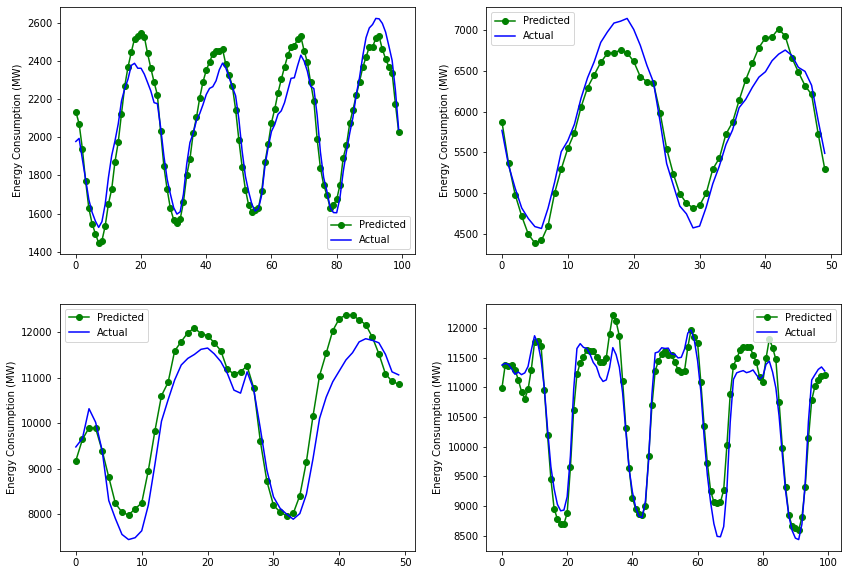

In [13]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(gru_outputs[0][-100:], "-o", color="g", label="Predicted")
plt.plot(targets[0][-100:], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.legend()

plt.subplot(2,2,2)
plt.plot(gru_outputs[8][-50:], "-o", color="g", label="Predicted")
plt.plot(targets[8][-50:], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.legend()

plt.subplot(2,2,3)
plt.plot(gru_outputs[4][:50], "-o", color="g", label="Predicted")
plt.plot(targets[4][:50], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.legend()

plt.subplot(2,2,4)
plt.plot(lstm_outputs[6][:100], "-o", color="g", label="Predicted")
plt.plot(targets[6][:100], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.show()